# Time Series - Exploratory Data Analysis (EDA)

## Analysis Documentation

To the initial analysis we need to understand if there is any business hypothesis that will help we predict the data and generate new hypothesis based on the analysis 

### Step by Step
- Remember time series properties
- Understanding the data
    - Looking deep into each row
    - Data quality checks
    - Gaphical Analysis
- Time series analysis
    - Seasonal Decompose
- Check products correlation

### Findings:
- ORDERNUMBER represent an big sale, ORDERLINENUMBER represent the products that the customer bought
- There are some natural segmentations that we need to be aware because the demand can be different for each segment:
    - STATUS
    - PRODUCTLINE
    - TERRITORY
    - DEALSIZE
- There are products without sales at some dates.
- There are seasonal effect at the month november
- There are products with similar sales (could we form clusters?).
- Each product has its specific seasonality.


### Doubts
- We have to validate with the business what kind of STATUS we are looking.
- The business team made any promotion during november?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tslearn.metrics import soft_dtw


plt.style.use('fivethirtyeight')

Database: https://www.kaggle.com/datasets/kyanyoga/sample-sales-data

In [2]:
df = pd.read_csv('../data/raw/sales_data_sample.csv', encoding="ISO-8859-1")

### Validating Properties

#### Type and Completeness

In [3]:
display(df.head(1))
df.info()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.7,2,2871.0,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [4]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


#### Uniqueness

In [5]:
df.nunique()

ORDERNUMBER          307
QUANTITYORDERED       58
PRICEEACH           1016
ORDERLINENUMBER       18
SALES               2763
ORDERDATE            252
STATUS                 6
QTR_ID                 4
MONTH_ID              12
YEAR_ID                3
PRODUCTLINE            7
MSRP                  80
PRODUCTCODE          109
CUSTOMERNAME          92
PHONE                 91
ADDRESSLINE1          92
ADDRESSLINE2           9
CITY                  73
STATE                 16
POSTALCODE            73
COUNTRY               19
TERRITORY              3
CONTACTLASTNAME       77
CONTACTFIRSTNAME      72
DEALSIZE               3
dtype: int64

In [10]:
print('Checking columns with low number of unique values')

display(df['STATUS'].value_counts())
display(df['PRODUCTLINE'].value_counts())
display(df['TERRITORY'].value_counts())
display(df['DEALSIZE'].value_counts())

Checking columns with low number of unique values


STATUS
Shipped       2617
Cancelled       60
Resolved        47
On Hold         44
In Process      41
Disputed        14
Name: count, dtype: int64

PRODUCTLINE
Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: count, dtype: int64

TERRITORY
EMEA     1407
APAC      221
Japan     121
Name: count, dtype: int64

DEALSIZE
Medium    1384
Small     1282
Large      157
Name: count, dtype: int64

#### Dates

In [12]:
print(df['ORDERDATE'].min())
print(df['ORDERDATE'].max())

2003-01-06 00:00:00
2005-05-31 00:00:00


In [17]:
df['dt_year_month'] = df['MONTH_ID'] + df['YEAR_ID'] * 100
df['dt_year_month'] = pd.to_datetime(df['dt_year_month'], format='%Y%m')
df['dt_year_month'].value_counts().sort_index()

dt_year_month
2003-01-01     39
2003-02-01     41
2003-03-01     50
2003-04-01     58
2003-05-01     58
2003-06-01     46
2003-07-01     50
2003-08-01     58
2003-09-01     76
2003-10-01    158
2003-11-01    296
2003-12-01     70
2004-01-01     91
2004-02-01     86
2004-03-01     56
2004-04-01     64
2004-05-01     74
2004-06-01     85
2004-07-01     91
2004-08-01    133
2004-09-01     95
2004-10-01    159
2004-11-01    301
2004-12-01    110
2005-01-01     99
2005-02-01     97
2005-03-01    106
2005-04-01     56
2005-05-01    120
Name: count, dtype: int64

### Graphical Analysis

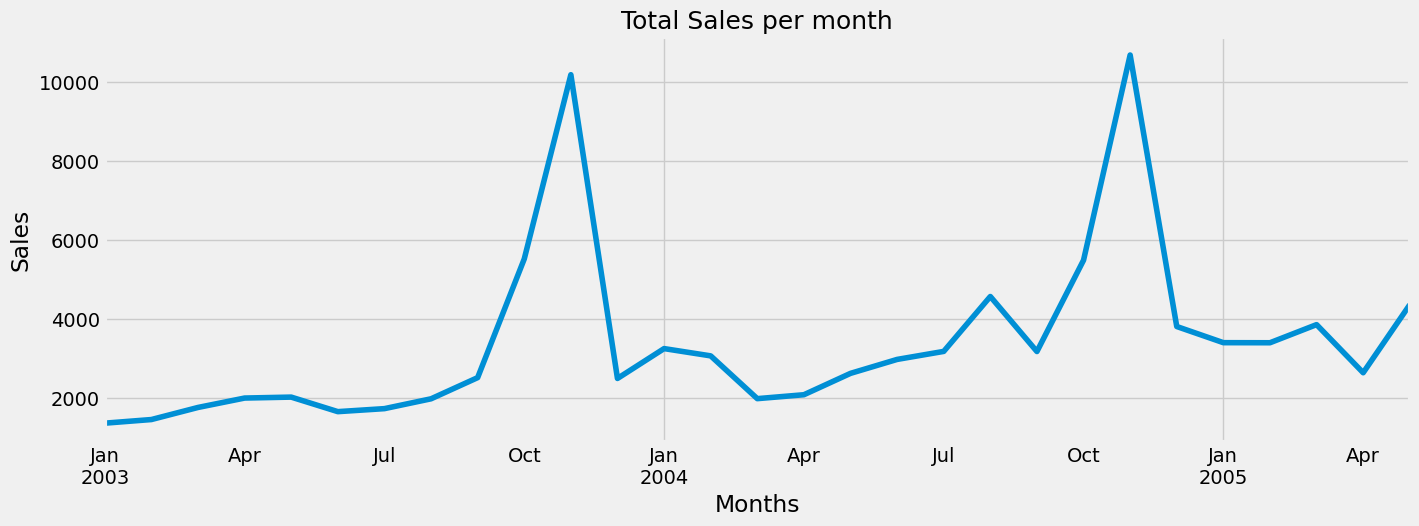

In [21]:
df_groupped = df.groupby(
    ['PRODUCTCODE', 'dt_year_month'], as_index=False).agg(
        qt_sales=('QUANTITYORDERED', 'sum'),
        qt_avg_price=('SALES', 'mean'))
df_groupped.sort_values(['PRODUCTCODE', 'dt_year_month'], inplace=True)

plt.figure(figsize=(15, 5))

df_total_sales = df_groupped.groupby('dt_year_month')['qt_sales'].sum()
df_total_sales.plot()
plt.xlabel('Months')
plt.ylabel('Sales')
plt.title('Total Sales per month', size=18)
plt.show()

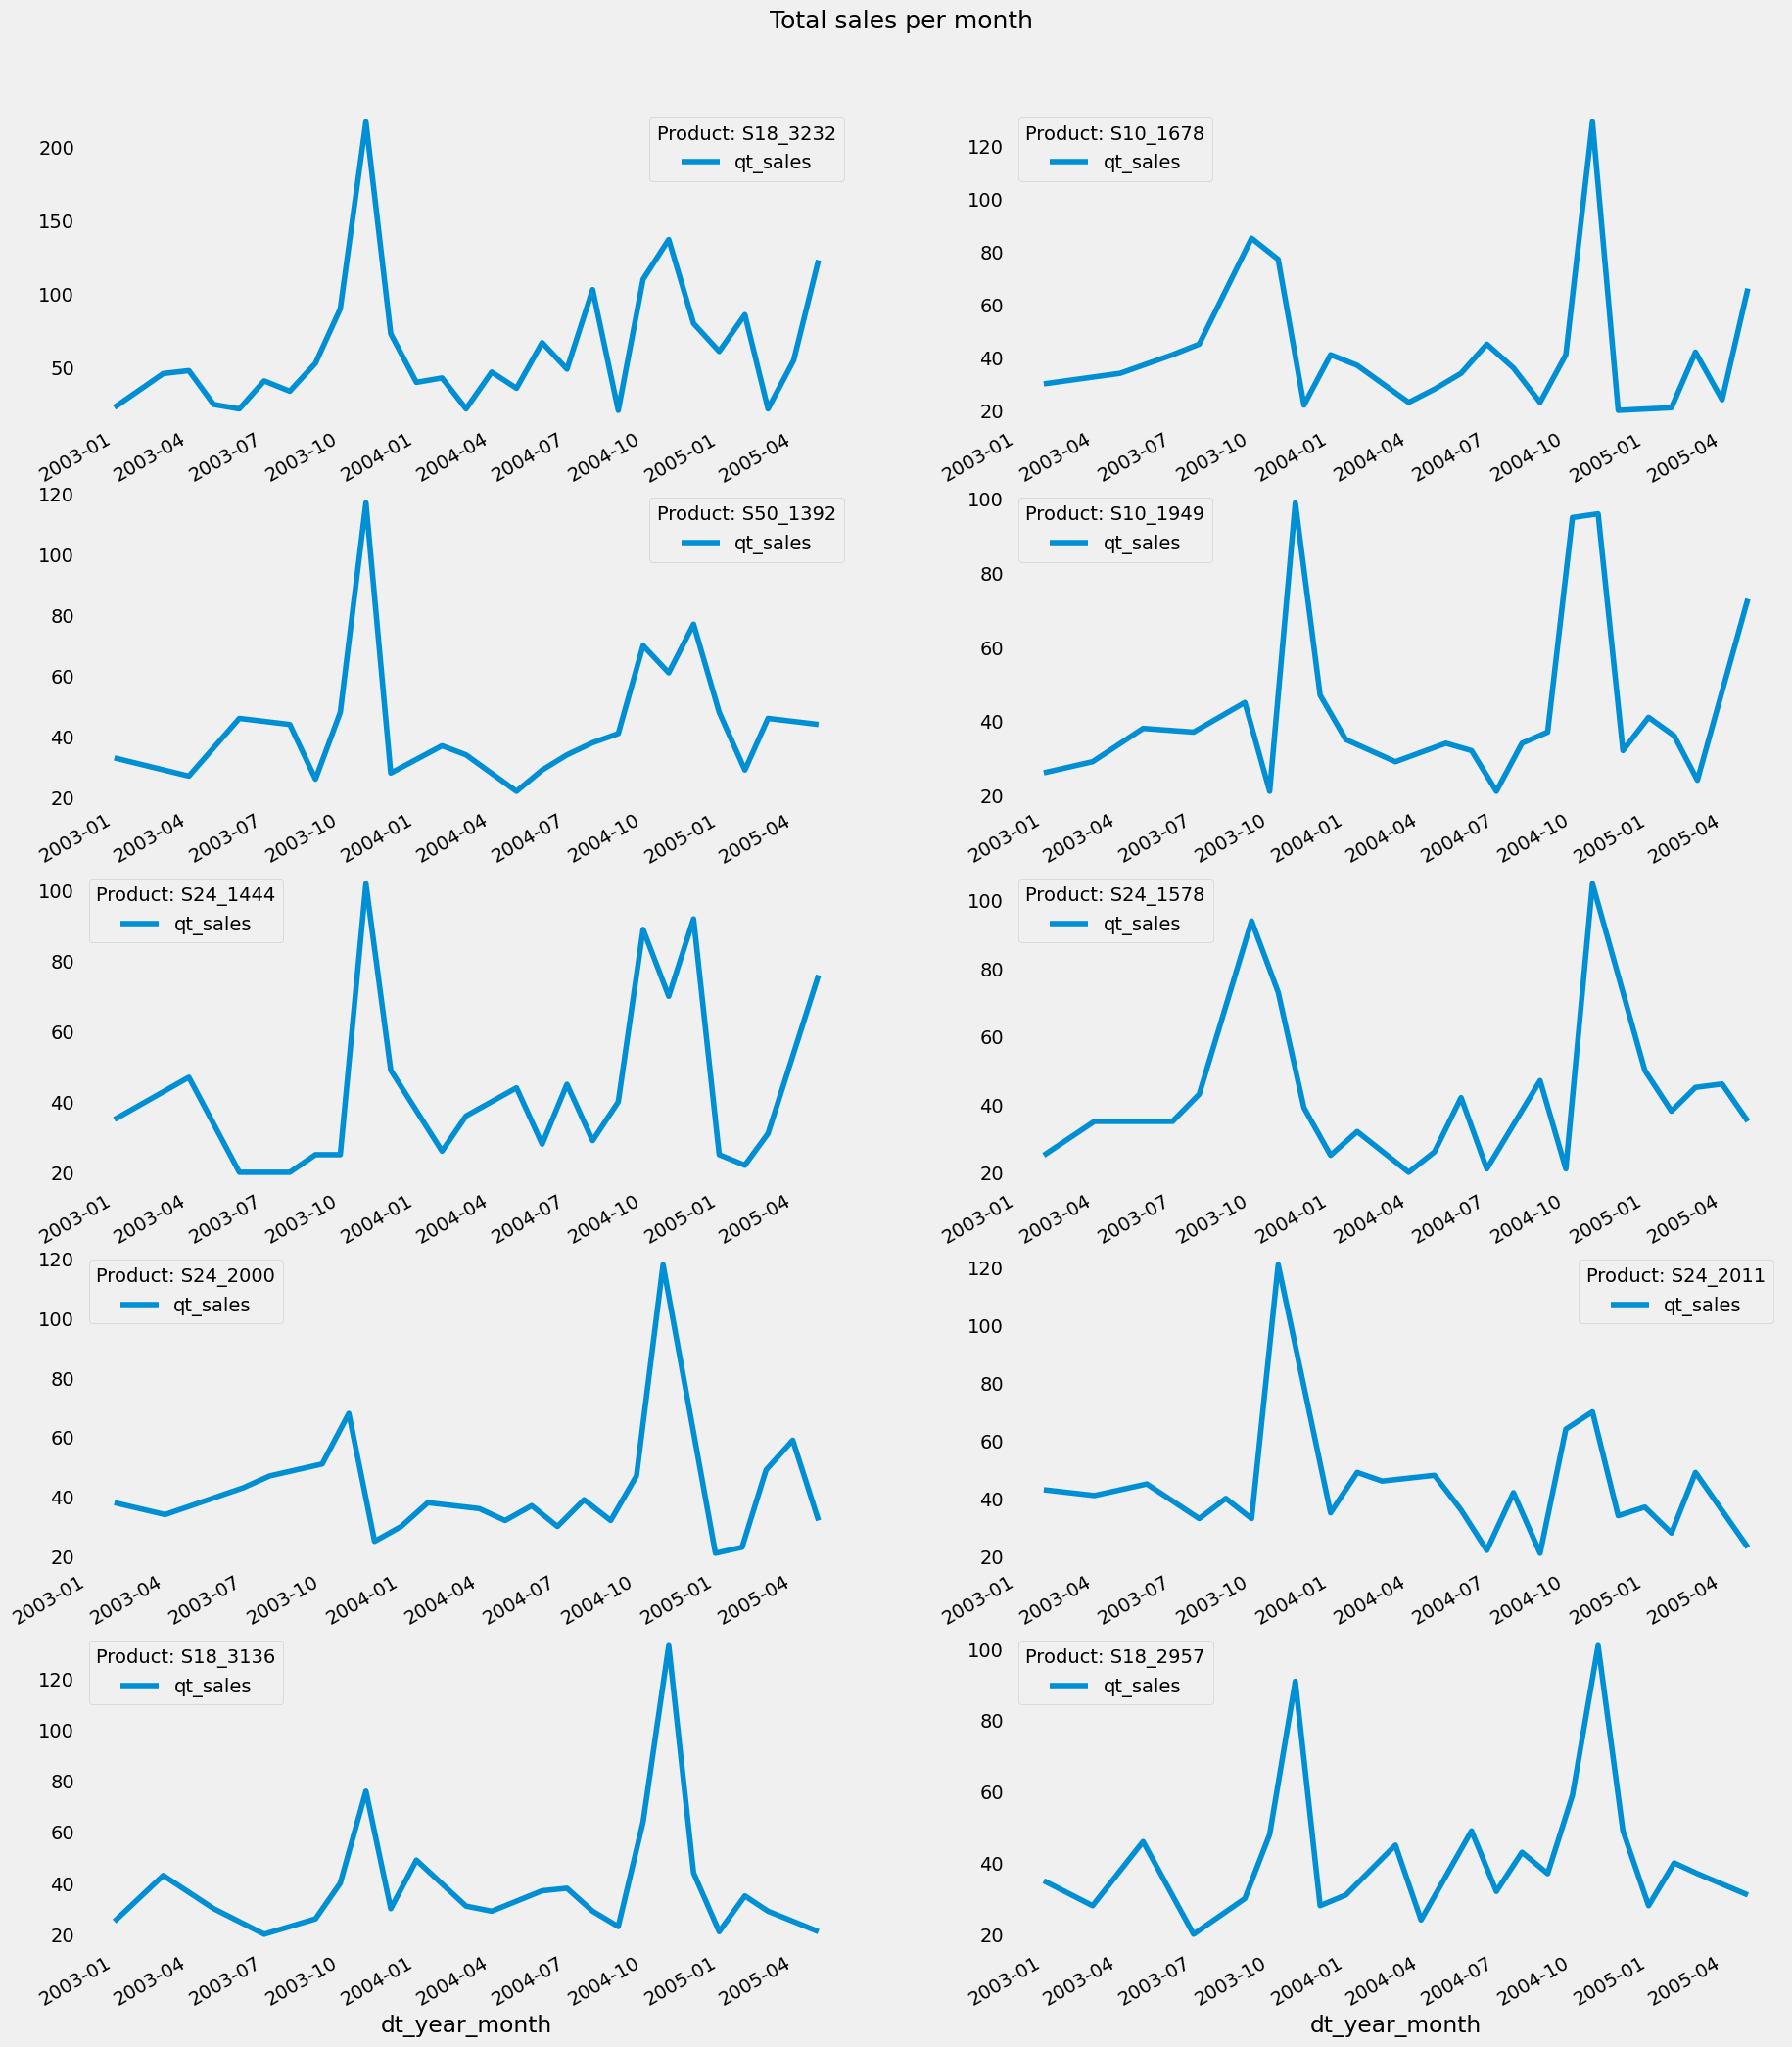

In [23]:
# Selecting products with high history
all_product_codes = (df_groupped
    .groupby('PRODUCTCODE').agg(
        qt_history=('dt_year_month', 'count'))
    .reset_index()
    .sort_values('qt_history', ascending=False)
    .head(10))['PRODUCTCODE'].unique()
all_product_codes


plt.figure(figsize=(20, 10))

for index, stock_code in enumerate(all_product_codes):
    size = len(all_product_codes)
    half_size = int(size/2)

    plt.subplot(half_size, 2, index + 1)
    ax = df_groupped[
        df_groupped['PRODUCTCODE'] == stock_code
    ].set_index('dt_year_month')['qt_sales'].plot()
    ax.grid(False)
    plt.legend(title=f'Product: {stock_code}')

plt.suptitle('Total sales per month', size=18)
plt.subplots_adjust(bottom=-1)
plt.show()

#### Seasonal Decompose

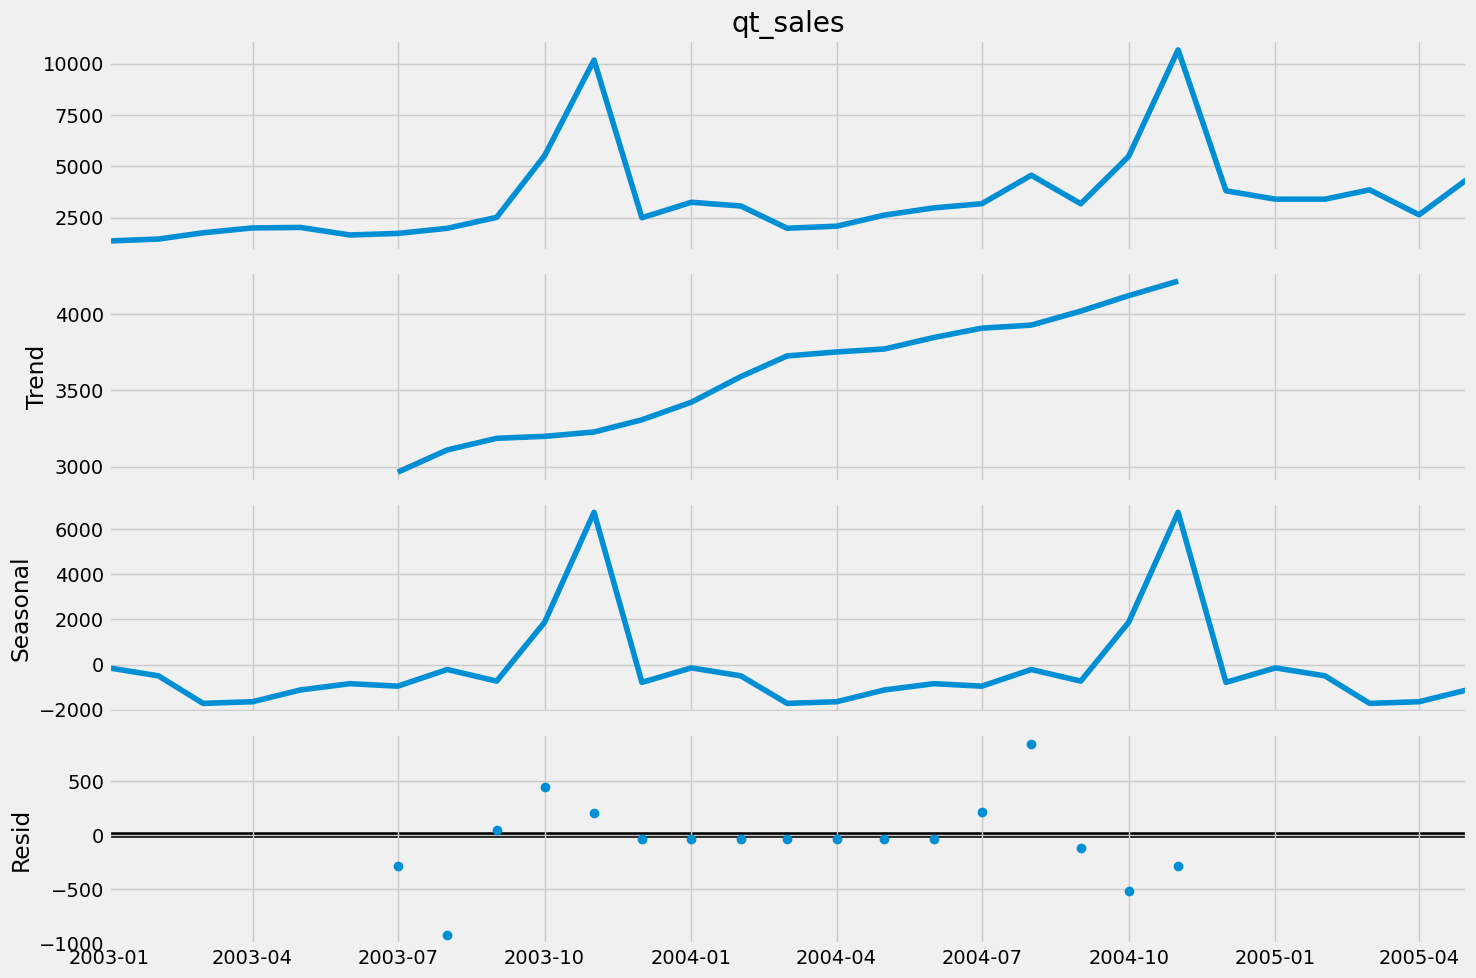

In [24]:
decomposed = seasonal_decompose(df_total_sales, model='additive', period=12)

fig = decomposed.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()

plt.show()


#### Partial Autocorrelation

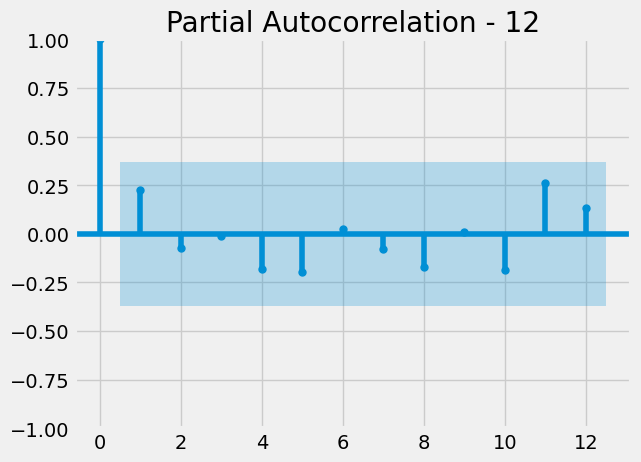

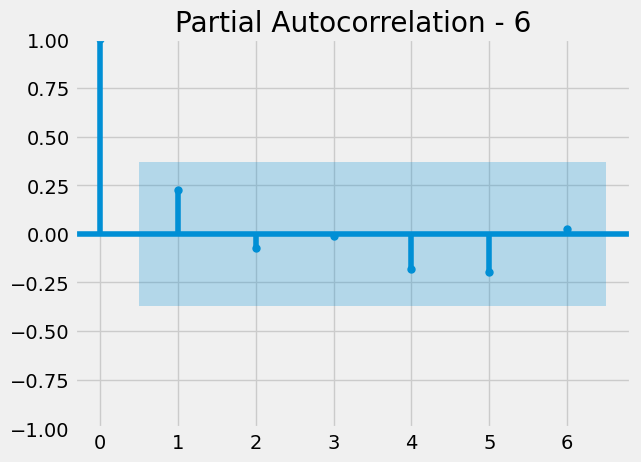

In [31]:
# Partial correlation from only one product
plot_pacf(df_groupped[
    df_groupped['PRODUCTCODE'] == all_product_codes[0]].set_index(
        'dt_year_month')['qt_sales'], lags=12,
        title='Partial Autocorrelation - 12')
plt.show()

plot_pacf(df_groupped[
    df_groupped['PRODUCTCODE'] == all_product_codes[0]].set_index(
        'dt_year_month')['qt_sales'], lags=6,
        title='Partial Autocorrelation - 6')
plt.show()


#### Time Series Clustering

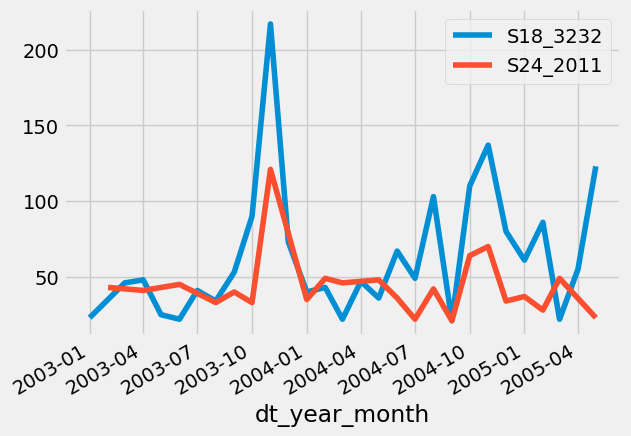

Pearson Correlation:


array([[1.        , 0.66397001],
       [0.66397001, 1.        ]])

--------------------
soft_dtw: 32643.0


In [32]:
product_1 = all_product_codes[0]
product_2 = all_product_codes[7]

df_product_1 = df_groupped[df_groupped['PRODUCTCODE'] == product_1].set_index(
    'dt_year_month')['qt_sales']
df_product_2 = df_groupped[df_groupped['PRODUCTCODE'] == product_2].set_index(
    'dt_year_month')['qt_sales']

df_product_1.plot()
df_product_2.plot()
plt.legend([product_1, product_2])
plt.show()

# Filtering to do the correlation only with the same dates
date_month_filter = list(
    set(df_product_1.index).intersection(df_product_2.index))
df_product_1_filtered = df_product_1[date_month_filter]
df_product_2_filtered = df_product_2[date_month_filter]

correlation = np.corrcoef(df_product_1_filtered, df_product_2_filtered)
print('Pearson Correlation:')
display(correlation)

print('--------------------')
print('soft_dtw:', soft_dtw(df_product_1_filtered, df_product_2_filtered, 
                            gamma=0.01))
